In [1]:
import torch
import pytorch_lightning as pl
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os 
import glob
import pandas as pd
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from itertools import combinations,permutations
import numpy as np
import random
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import wandb

In [2]:
df=pd.read_csv('./Data/labels.csv')
df.head()

,Site,Pose,Path,label
0,Big Ben,Peace,./Data/Big Ben/Peace/Firefox_Screenshot_2022-0...,Big Ben::Peace
1,Big Ben,Peace,./Data/Big Ben/Peace/Firefox_Screenshot_2022-0...,Big Ben::Peace
2,Big Ben,Br├╝cke,./Data/Big Ben/Br├╝cke/Firefox_Screenshot_2022...,Big Ben::Br├╝cke
3,Big Ben,Br├╝cke,./Data/Big Ben/Br├╝cke/Firefox_Screenshot_2022...,Big Ben::Br├╝cke
4,Big Ben,Telefon,./Data/Big Ben/Telefon/Firefox_Screenshot_2022...,Big Ben::Telefon


In [3]:
# Generating Pairs from images
pairImages=[]
pairLabels=[]
pairMeta=[]
for label in df.label.unique():
    if(label.split('::')[1]=='_zz'):
        pass
    else:
        data=df[df.label==label]
        positives=list(combinations(data.index,2))

        # Generating Negative Pairs with same Number as Positive Pairs
        site=data.Site.values[0]
        pose=data.Pose.values[0]
        
        # getting all examples from same site but different pose 
        data=df[(df.label!=label) & (df.Site==site)]
        


        for pair in positives:

            anchor=pair[0]
            neg=random.choice(data.index)


            anchor_row=df.iloc[pair[0]]
            pos_image=df.iloc[pair[1]]
            neg_image=df.iloc[neg]


            # Positive Pairs
            pairImages.append([anchor_row.Path,pos_image.Path])
            pairMeta.append([anchor_row.label,pos_image.label])
            pairLabels.append([1])


            # Negative Pairs
            pairImages.append([anchor_row.Path,neg_image.Path])
            pairMeta.append([anchor_row.label,neg_image.label])
            pairLabels.append([0])

    
        
    # print (data)"
    # print ()

In [4]:
def read_image(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 



def compute_features(model,image):
    scaler = transforms.Resize((224, 224))
    to_tensor = transforms.ToTensor()
    t_img=Variable(to_tensor(scaler(Image.fromarray(image)))).unsqueeze(0)
    return model(t_img).detach().numpy()



def calculate_similarity_cosine(vector1, vector2):
 #return 1 - distance.cosine(vector1, vector2)
    return cosine_similarity(vector1, vector2)

# This distance can be in range of [0,∞]. And this distance is converted to a [0,1]
def calculate_similarity_euclidean(vector1, vector2):
    return 1/(1 + np.linalg.norm(vector1- vector2))  




In [5]:
model=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

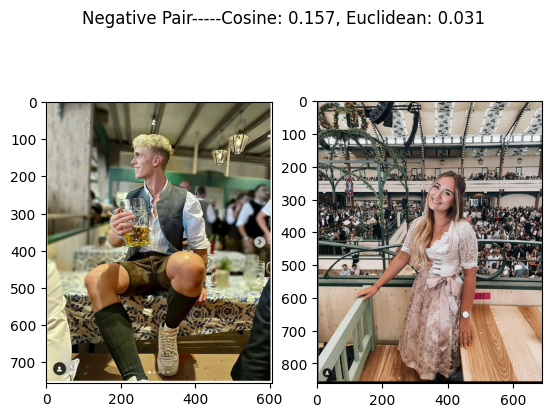

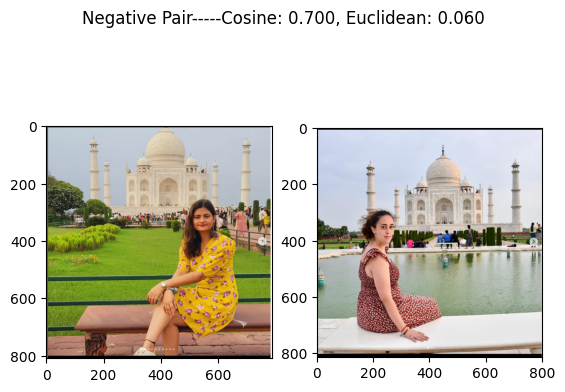

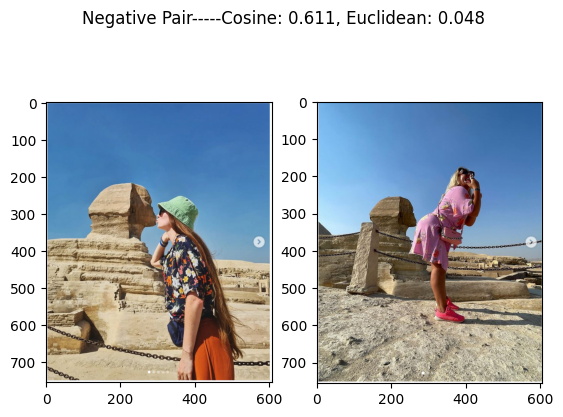

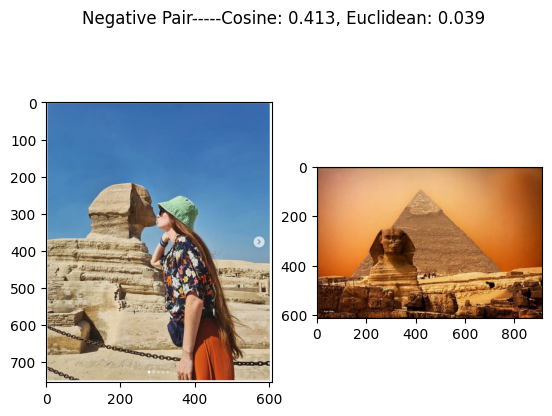

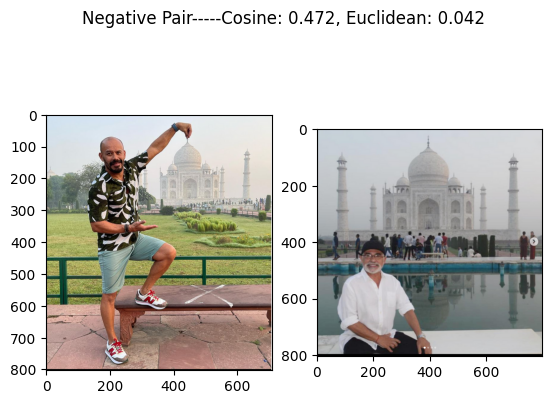

In [6]:
for i in range(0,5):


    idx=random.randint(0,len(pairImages)-1)
    
    imageA=read_image(pairImages[idx][0])
    imageB=read_image(pairImages[idx][1])
    poseA=pairMeta[idx][0]
    poseB=pairMeta[idx][1]
    label=pairLabels[idx]


    featA=compute_features(model,imageA)
    featB=compute_features(model,imageB)

    cosine_sim=calculate_similarity_cosine(featA,featB)
    distance=calculate_similarity_euclidean(featA,featB)
    
    # print (cosine_sim,distance)

    if(label[0]==1):
        title="Positive Pair-----Cosine: {:.3f}, Euclidean: {:.3f} ".format(cosine_sim[0][0],distance)
    else:
        title="Negative Pair-----Cosine: {:.3f}, Euclidean: {:.3f} ".format(cosine_sim[0][0],distance)


    # fig=make_subplots(rows=1,cols=2)

    # fig.add_trace(go.Image(z=imageA),row=1,col=1)
    # fig.add_trace(go.Image(z=imageB),row=1,col=2)   
    # fig.update_layout(title_text=title, title_x=0.5)
    # fig.show()


    # wandb.log({"Output":fig})




    f,ax=plt.subplots(1,2)
    ax[0].imshow(imageA)
    ax[1].imshow(imageB)

    f.suptitle(title)




    


    
    

